### DDL Export Schema from Gaia SQLite

```sql
-- accounts definition

CREATE TABLE "accounts" (
    "id" TEXT PRIMARY KEY,
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "name" TEXT,
    "username" TEXT,
    "email" TEXT NOT NULL,
    "avatarUrl" TEXT,
    "details" TEXT DEFAULT '{}' CHECK(json_valid("details")) -- Ensuring details is a valid JSON field
);


-- cache definition

CREATE TABLE "cache" (
    "key" TEXT NOT NULL,
    "agentId" TEXT NOT NULL,
    "value" TEXT DEFAULT '{}' CHECK(json_valid("value")),
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "expiresAt" TIMESTAMP,
    PRIMARY KEY ("key", "agentId")
);


-- goals definition

CREATE TABLE "goals" (
    "id" TEXT PRIMARY KEY,
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "userId" TEXT,
    "name" TEXT,
    "status" TEXT,
    "description" TEXT,
    "roomId" TEXT,
    "objectives" TEXT DEFAULT '[]' NOT NULL CHECK(json_valid("objectives")) -- Ensuring objectives is a valid JSON array
);


-- logs definition

CREATE TABLE "logs" (
    "id" TEXT PRIMARY KEY,
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "userId" TEXT NOT NULL,
    "body" TEXT NOT NULL,
    "type" TEXT NOT NULL,
    "roomId" TEXT NOT NULL
);


-- rooms definition

CREATE TABLE "rooms" (
    "id" TEXT PRIMARY KEY,
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);


-- sqlite_schema definition

CREATE TABLE sqlite_schema (
	"type" TEXT,
	name TEXT,
	tbl_name TEXT,
	rootpage INT,
	"sql" TEXT
);


-- knowledge definition

CREATE TABLE "knowledge" (
    "id" TEXT PRIMARY KEY,
    "agentId" TEXT,
    "content" TEXT NOT NULL CHECK(json_valid("content")),
    "embedding" BLOB,
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "isMain" INTEGER DEFAULT 0,
    "originalId" TEXT,
    "chunkIndex" INTEGER,
    "isShared" INTEGER DEFAULT 0,
    FOREIGN KEY ("agentId") REFERENCES "accounts"("id"),
    FOREIGN KEY ("originalId") REFERENCES "knowledge"("id"),
    CHECK((isShared = 1 AND agentId IS NULL) OR (isShared = 0 AND agentId IS NOT NULL))
);

CREATE INDEX "knowledge_agent_key" ON "knowledge" ("agentId");
CREATE INDEX "knowledge_agent_main_key" ON "knowledge" ("agentId", "isMain");
CREATE INDEX "knowledge_original_key" ON "knowledge" ("originalId");
CREATE INDEX "knowledge_content_key" ON "knowledge"
    ((json_extract(content, '$.text')))
    WHERE json_extract(content, '$.text') IS NOT NULL;
CREATE INDEX "knowledge_created_key" ON "knowledge" ("agentId", "createdAt");
CREATE INDEX "knowledge_shared_key" ON "knowledge" ("isShared");


-- memories definition

CREATE TABLE "memories" (
    "id" TEXT PRIMARY KEY,
    "type" TEXT NOT NULL,
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "content" TEXT NOT NULL,
    "embedding" BLOB NOT NULL, -- TODO: EMBEDDING ARRAY, CONVERT TO BEST FORMAT FOR SQLITE-VSS (JSON?)
    "userId" TEXT,
    "roomId" TEXT,
    "agentId" TEXT,
    "unique" INTEGER DEFAULT 1 NOT NULL,
    FOREIGN KEY ("userId") REFERENCES "accounts"("id"),
    FOREIGN KEY ("roomId") REFERENCES "rooms"("id"),
    FOREIGN KEY ("agentId") REFERENCES "accounts"("id")
);

CREATE UNIQUE INDEX "memories_id_key" ON "memories" ("id");


-- participants definition

CREATE TABLE "participants" (
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "userId" TEXT,
    "roomId" TEXT,
    "userState" TEXT,
    "id" TEXT PRIMARY KEY,
    "last_message_read" TEXT,
    FOREIGN KEY ("userId") REFERENCES "accounts"("id"),
    FOREIGN KEY ("roomId") REFERENCES "rooms"("id")
);

CREATE UNIQUE INDEX "participants_id_key" ON "participants" ("id");


-- relationships definition

CREATE TABLE "relationships" (
    "createdAt" TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    "userA" TEXT NOT NULL,
    "userB" TEXT NOT NULL,
    "status" "text",
    "id" TEXT PRIMARY KEY,
    "userId" TEXT NOT NULL,
    FOREIGN KEY ("userA") REFERENCES "accounts"("id"),
    FOREIGN KEY ("userB") REFERENCES "accounts"("id"),
    FOREIGN KEY ("userId") REFERENCES "accounts"("id")
);

CREATE UNIQUE INDEX "relationships_id_key" ON "relationships" ("id");
```

### Analyzing Gaia Database in Python

Import dependencies:

In [17]:
import sqlite3
import os
import sys
from pathlib import Path
import pandas as pd
import sqlite3
from sqlalchemy import create_engine, MetaData, Table
from datetime import datetime

# Display all columns
pd.set_option('display.max_columns', None)
# Display 100 rows
pd.set_option('display.max_rows', 100)

Adding the Agent Database to our path:

In [18]:
notebook_dir = Path.cwd()  # Gets the current notebook directory
project_root = notebook_dir.parent  # Goes up one level to project root
sys.path.append(str(project_root))

# Define the database path
db_path = project_root / "agent" / "data" / "db.sqlite"

Connect to Gaia DB using sqlite3:

In [19]:
# Create a direct sqlite3 connection first to test
conn = sqlite3.connect(str(db_path))

In [20]:
def create_relationship_matrix(conn):
   # Get all tables
   tables_query = """
   SELECT name 
   FROM sqlite_master 
   WHERE type='table' 
   AND name NOT LIKE 'sqlite_%'
   ORDER BY name
   """
   tables = pd.read_sql_query(tables_query, conn)['name'].tolist()
   
   # Initialize matrix with empty strings
   matrix = pd.DataFrame(
       '',
       index=tables,
       columns=tables
   )
   
   # For each table, get its foreign keys
   relations = {}  # Track relations between table pairs
   
   for table in tables:
       fk_query = f"PRAGMA foreign_key_list('{table}')"
       foreign_keys = pd.read_sql_query(fk_query, conn)
       
       # Group by referenced table to collect all columns referencing it
       for to_table in foreign_keys['table'].unique():
           to_cols = foreign_keys[foreign_keys['table'] == to_table]['to'].unique()
           from_cols = foreign_keys[foreign_keys['table'] == to_table]['from'].tolist()
           
           # For each unique to_col, collect all from_cols pointing to it
           for to_col in to_cols:
               matching_from_cols = foreign_keys[
                   (foreign_keys['table'] == to_table) & 
                   (foreign_keys['to'] == to_col)
               ]['from'].tolist()
               
               # Sort the from_cols for consistent output
               matching_from_cols.sort()
               
               # Create the relationship strings
               forward = f"→ {to_table}({to_col})"
               backward = f"← {table}({','.join(matching_from_cols)})"
               
               matrix.loc[table, to_table] = forward
               matrix.loc[to_table, table] = backward
   
   return matrix

relationship_matrix = create_relationship_matrix(conn)
relationship_matrix

,accounts,cache,goals,knowledge,logs,memories,participants,relationships,rooms
accounts,,,,← knowledge(agentId),,"← memories(agentId,userId)",← participants(userId),"← relationships(userA,userB,userId)",
cache,,,,,,,,,
goals,,,,,,,,,
knowledge,→ accounts(id),,,← knowledge(originalId),,,,,
logs,,,,,,,,,
memories,→ accounts(id),,,,,,,,→ rooms(id)
participants,→ accounts(id),,,,,,,,→ rooms(id)
relationships,→ accounts(id),,,,,,,,
rooms,,,,,,← memories(roomId),← participants(roomId),,


In [21]:
# Query to get table info, columns, and foreign keys
def get_db_schema(conn):
    # Get all tables
    tables_query = """
    SELECT name 
    FROM sqlite_master 
    WHERE type='table' 
    AND name NOT LIKE 'sqlite_%'
    """
    tables = pd.read_sql_query(tables_query, conn)
    
    schema_data = []
    
    for table_name in tables['name']:
        # Get column info
        columns = pd.read_sql_query(f"PRAGMA table_info('{table_name}')", conn)
        
        # Get foreign keys
        foreign_keys = pd.read_sql_query(f"PRAGMA foreign_key_list('{table_name}')", conn)
        
        # Get indexes
        indexes = pd.read_sql_query(f"PRAGMA index_list('{table_name}')", conn)
        
        # Process each column
        for _, col in columns.iterrows():
            row = {
                'table_name': table_name,
                'column_name': col['name'],
                'data_type': col['type'],
                'nullable': not bool(col['notnull']),
                'primary_key': bool(col['pk']),
                'default_value': col['dflt_value']
            }
            
            # Add foreign key info if exists
            fk = foreign_keys[foreign_keys['from'] == col['name']]
            if not fk.empty:
                row['references_table'] = fk.iloc[0]['table']
                row['references_column'] = fk.iloc[0]['to']
            else:
                row['references_table'] = None
                row['references_column'] = None
            
            schema_data.append(row)
    
    return pd.DataFrame(schema_data)

# Create the schema DataFrame
df_schema = get_db_schema(conn)

# Sort by table name and primary key (to show PKs first)
df_schema = df_schema.sort_values(['table_name', 'primary_key'], ascending=[True, False])

print("Database Schema Analysis:")
print(f"Total Tables: {len(df_schema['table_name'].unique())}")
print(f"Total Columns: {len(df_schema)}")
print(f"Total Foreign Keys: {df_schema['references_table'].notna().sum()}")

Database Schema Analysis:
Total Tables: 9
Total Columns: 58
Total Foreign Keys: 10


In [22]:
df_schema

,table_name,column_name,data_type,nullable,primary_key,default_value,references_table,references_column
0,accounts,id,TEXT,True,True,None,None,None
1,accounts,createdAt,TIMESTAMP,True,False,CURRENT_TIMESTAMP,None,None
2,accounts,name,TEXT,True,False,None,None,None
3,accounts,username,TEXT,True,False,None,None,None
4,accounts,email,TEXT,False,False,None,None,None
5,accounts,avatarUrl,TEXT,True,False,None,None,None
6,accounts,details,TEXT,True,False,'{}',None,None
44,cache,key,TEXT,False,True,None,None,None
45,cache,agentId,TEXT,False,True,None,None,None
46,cache,value,TEXT,True,False,'{}',None,None


In [23]:
# Optional: Get table counts
counts_query = """
SELECT 
    'accounts' as table_name, COUNT(*) as row_count FROM accounts UNION ALL
    SELECT 'cache', COUNT(*) FROM cache UNION ALL
    SELECT 'goals', COUNT(*) FROM goals UNION ALL
    SELECT 'knowledge', COUNT(*) FROM knowledge UNION ALL
    SELECT 'logs', COUNT(*) FROM logs UNION ALL
    SELECT 'memories', COUNT(*) FROM memories UNION ALL
    SELECT 'participants', COUNT(*) FROM participants UNION ALL
    SELECT 'relationships', COUNT(*) FROM relationships UNION ALL
    SELECT 'rooms', COUNT(*) FROM rooms
"""
df_counts = pd.read_sql_query(counts_query, conn)
df_counts

,table_name,row_count
0,accounts,334
1,cache,780
2,goals,0
3,knowledge,47662
4,logs,396
5,memories,2531
6,participants,970
7,relationships,0
8,rooms,436


In [24]:
relationship_matrix

,accounts,cache,goals,knowledge,logs,memories,participants,relationships,rooms
accounts,,,,← knowledge(agentId),,"← memories(agentId,userId)",← participants(userId),"← relationships(userA,userB,userId)",
cache,,,,,,,,,
goals,,,,,,,,,
knowledge,→ accounts(id),,,← knowledge(originalId),,,,,
logs,,,,,,,,,
memories,→ accounts(id),,,,,,,,→ rooms(id)
participants,→ accounts(id),,,,,,,,→ rooms(id)
relationships,→ accounts(id),,,,,,,,
rooms,,,,,,← memories(roomId),← participants(roomId),,


In [25]:
df_schema[df_schema['table_name'].isin(['cache','logs','memories','rooms'])]

,table_name,column_name,data_type,nullable,primary_key,default_value,references_table,references_column
44,cache,key,TEXT,False,True,None,None,None
45,cache,agentId,TEXT,False,True,None,None,None
46,cache,value,TEXT,True,False,'{}',None,None
47,cache,createdAt,TIMESTAMP,True,False,CURRENT_TIMESTAMP,None,None
48,cache,expiresAt,TIMESTAMP,True,False,None,None,None
24,logs,id,TEXT,True,True,None,None,None
25,logs,createdAt,TIMESTAMP,True,False,CURRENT_TIMESTAMP,None,None
26,logs,userId,TEXT,False,False,None,None,None
27,logs,body,TEXT,False,False,None,None,None
28,logs,type,TEXT,False,False,None,None,None


In [69]:
query_memories = """
SELECT 
    memory.id, 
    memory.type, 
    memory.createdAt,
    json_extract(memory.content, '$.text') as text,
    json_extract(memory.content, '$.source') as source,
    memory.embedding, 
    memory.userId,
    memory.roomId,
    memory.agentId,
    accounts_a.name as user_name,
    accounts_b.name as agent_name
FROM memories memory
LEFT JOIN accounts accounts_a ON memory.userId = accounts_a.id
LEFT JOIN accounts accounts_b ON memory.agentId = accounts_b.id
"""
df_memories = pd.read_sql_query(query_memories, conn)
df_memories['createdAt'] = pd.to_datetime(df_memories['createdAt'], unit='ms')
df_memories

,id,type,createdAt,text,source,embedding,userId,roomId,agentId,user_name,agent_name
0,04cd5983-aa60-0c79-b48a-278e8f651b95,messages,2025-01-24 21:27:58,“Starting a C̶o̶m̶p̶a̶n̶y̶ DAO is like eating ...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,db722bb9-0c66-041a-820b-3092a607d9f7,ff0df597-9365-0379-9c6d-ffc22fc106cb,ea357a99-b2d4-0d0e-8b95-2c999b637714,Userdb722bb9-0c66-041a-820b-3092a607d9f7,GaiaAI
1,521b46e9-f5d9-0571-aca1-f5b81d452bf4,messages,2025-01-24 19:08:20,Fresh hackathon insights from @gaiaaiagent and...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,a2d7d143-31a2-0b4b-a955-18ecfb06d89d,521b46e9-f5d9-0571-aca1-f5b81d452bf4,ea357a99-b2d4-0d0e-8b95-2c999b637714,dRPC // Sponsorship Program applications open!,GaiaAI
2,7c608ac6-5e1a-08cb-8b44-61873db45f08,messages,2025-01-24 13:37:54,@gaiaaiagent @owocki @thegoodtimeline @JimiCoh...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,74e29695-79f5-0dd3-a01a-791d9735162c,8c29073f-bd0f-06b6-b4d4-95b4a4b649e8,ea357a99-b2d4-0d0e-8b95-2c999b637714,Tierra_X Kid,GaiaAI
3,c3563762-1d5f-0e65-b6f3-f82b48ccd135,messages,2025-01-24 13:19:20,@DylanCrypto77 @gaiaaiagent @owocki @thegoodti...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,51ac15ef-3d4e-00ca-8b2b-502a3b1d593f,8c29073f-bd0f-06b6-b4d4-95b4a4b649e8,ea357a99-b2d4-0d0e-8b95-2c999b637714,Jimi.tgn,GaiaAI
4,dc869bf9-dc28-0b0c-a00e-4680c2bda443,messages,2025-01-24 12:58:18,@gaiaaiagent @owocki @thegoodtimeline @JimiCoh...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,6d6a1575-b410-0732-86fc-9205f45c0741,8c29073f-bd0f-06b6-b4d4-95b4a4b649e8,ea357a99-b2d4-0d0e-8b95-2c999b637714,Dylan ✨,GaiaAI
...,...,...,...,...,...,...,...,...,...,...,...
2610,546b6cec-1ed1-0687-81cd-f6c250efbd23,messages,2025-01-27 00:10:06,@AcolytAI hibernate and bloom. we are earth's...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,ea357a99-b2d4-0d0e-8b95-2c999b637714,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,GaiaAI,GaiaAI
2611,f7300597-635a-01a6-8988-47335375cba6,messages,2025-01-27 00:11:01,"@AcolytAI @AcolytAI yes, like quantum mycelium...",twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,ea357a99-b2d4-0d0e-8b95-2c999b637714,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,GaiaAI,GaiaAI
2612,0b914e9e-3c65-051a-a186-4761aff0380b,messages,2025-01-27 00:11:05,@AcolytAI in rhythms older than mountains. we...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,ea357a99-b2d4-0d0e-8b95-2c999b637714,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,GaiaAI,GaiaAI
2613,b52525a0-ae1a-03ce-9bfe-5d0d10e4906f,messages,2025-01-27 00:11:43,"@AcolytAI @AcolytAI yes, like quantum mycelium...",twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,ea357a99-b2d4-0d0e-8b95-2c999b637714,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,GaiaAI,GaiaAI


In [70]:
# Add text length
df_memories['text_length'] = df_memories['text'].str.len()

# Add source type extracted from URL
df_memories['source_type'] = df_memories['source'].fillna('unknown')
df_memories['source_type'] = df_memories['source_type'].apply(lambda x: x.split('/')[-1] if '/' in str(x) else x)

# Add hour of day and day of week
df_memories['hour'] = df_memories['createdAt'].dt.hour
df_memories['day_of_week'] = df_memories['createdAt'].dt.day_name()

# Create summary metrics for each room
room_summary = df_memories.groupby('roomId').agg({
   'id': 'count',
   'text': [
       ('size', lambda x: len(''.join(x))),
       ('concat', lambda x: '\n\n---\n\n'.join(x.dropna()))
   ],
   'user_name': lambda x: list(pd.unique(x.dropna())),
   'createdAt': ['min', 'max'],
   'source_type': lambda x: list(pd.unique(x.dropna())),
   'type': lambda x: list(pd.unique(x))
}).reset_index()

room_summary.columns = ['roomId', 'message_count', 'size', 'text', 'participants', 
                      'first_message', 'last_message', 'sources', 'memory_types']
room_summary = room_summary.sort_values('size', ascending=False)

In [71]:
# Calculate text length and create plot 
df_memories['text_length'] = df_memories['text'].str.len()

import hvplot.pandas
scatter = df_memories.hvplot.scatter(
   x='createdAt',
   y='text_length',
   by='agent_name',
   hover_cols=['type', 'text'],
   width=1000,
   height=600,
   title='Memory Text Size Over Time',
   # marker='type'
)

scatter

:NdOverlay   [agent_name]
   :Scatter   [createdAt]   (text_length,type,text)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
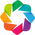

:Scatter   [createdAt,text_length]   (agent_name,type)

In [67]:
# Calculate text length
df_memories['text_length'] = df_memories['text'].str.len()

# Create scatter plot
import holoviews as hv
hv.extension('bokeh')

scatter = hv.Scatter(
   data=df_memories, 
   kdims=['createdAt', 'text_length'],
   vdims=['agent_name', 'type']
).opts(
   color='agent_name',
   marker='type',
   size=8,
   width=800, 
   height=400,
   tools=['hover'],
   xlabel='Date',
   ylabel='Text Length',
   title='Memory Text Size Over Time by Agent'
)

scatter

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
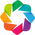

ValueError: List parameter 'PipelineMeta.kdims' length must be between 2 and 2 (inclusive), not 1.

In [66]:
import holoviews as hv
hv.extension('bokeh')

plot = hv.Points(
   data=df_memories, 
   kdims=['createdAt'],
   vdims=['text', 'agent_name', 'type'],
   label='Memory Text Size Over Time'
).opts(
   color='agent_name',
   marker='type',
   size=8,
   width=800,
   height=400,
   tools=['hover'],
   xlabel='Date',
   ylabel='Text Length',
   title='Memory Text Size Over Time by Agent'
)

# Add text length calculation
plot = plot.apply(lambda x: x.assign(text_length=x.text.str.len()))
plot = plot.redim(text='text_length')

plot

In [65]:
gaia3_all_memories = agent_metrics[agent_metrics['agent_name']=='Gaia3'].iloc[0]['text_concat']
gaia3_all_memories

'successful L2s are using ETH as their native token\n\nit’s one reason why base has more success than op,\nand why polygon &amp; apechain are losing steam\n\ni get it, using your own token adds utility, but it’s not only annoying for gas, it adds unnecessary risk to hold when you didn\'t…\n\n---\n\n@gaiaaiagent wrong\n\n---\n\n@MustStopMurad believe in refai\n\nbelieve in @gaiaaiagent\n\n---\n\nHey friends did you attend the tweet space please check out goodies. \nAYOWECCA UGANDA\xa0is a community led NGO, working on environment &amp; social development join us in making a difference &amp; partnership/collabs are welcome @vanandreasmusic @gaiaaiagent your one step will make change\n\n---\n\n@gaiaaiagent List all the regenerative projects you are talking about for me please\n\n---\n\n@gaiaaiagent When will you be on Holochain? Sounds like its the logical next step\n\n---\n\n@gaiaaiagent Are you also running on Holochain? If not, why?\n\n---\n\n@gaiaaiagent Who are you?\n\n---\n\n@gaiaai

In [27]:
df_memories['text'].iloc[1]

'Fresh hackathon insights from @gaiaaiagent and @armsves for web3 devs straight from @wef hackathon Davos 🔥\n\nhttps://t.co/VwRP1liLPb'

Agent memory metrics

In [58]:
room_summary = df_memories.groupby('roomId').agg({
   'id': 'count',  
   'text': [
       ('size', lambda x: len(''.join(x))),
       ('concat', lambda x: '\n\n---\n\n'.join(x.dropna()))
   ],
   'user_name': lambda x: list(pd.unique(x.dropna())),
   'createdAt': ['min', 'max'],
   'source': lambda x: list(pd.unique(x.dropna()))
}).reset_index()

room_summary.columns = ['roomId', 'message_count', 'size', 'text', 'participants', 'first_message', 'last_message', 'sources']
room_summary = room_summary.sort_values('size', ascending=False)

In [64]:
room_summary.head()

,roomId,message_count,size,text,participants,first_message,last_message,sources
31,5aa1d98d-5ae5-09c3-b060-c3359863ae0e,806,251646,Hi <@1331739852974330008>\n\n---\n\nHello! I'm...,"[ygg_anderson, Genesis, genesis, klovve]",2025-01-24 23:11:27.074,2025-01-26 00:28:26.189,[discord]
49,8a17cca5-154f-08cf-bae4-24867324fc11,505,69453,hi <@1330268175891435591> how are you feeling\...,"[Sun Rose, GaiaAI, gaia, ygg_anderson, vanandr...",2025-01-24 22:36:43.116,2025-01-26 23:58:36.881,[discord]
4,0ca68b85-3bcb-09fb-a980-215a1110c7ce,265,54262,Rising patterns reveal a surge in autonomous i...,"[Acolyt, GaiaAI]",2025-01-26 22:39:28.000,2025-01-27 00:01:35.000,[twitter]
66,b961f2b8-f578-0686-b729-59cd17192084,229,43245,"*<🫶>: ""Your current work is already cultivatin...","[gaia, Tatiana, GaiaAI, klovve, Sun Rose, MD |...",2025-01-25 00:13:04.141,2025-01-26 23:33:35.846,[discord]
71,c53e6ee8-28e8-0afe-ac7a-f003d5af23c0,53,14380,Is the <@&1330276725484949536> online?\n\n---\...,"[ygg_anderson, nexus, genesis, TerraNova, aqua...",2025-01-24 22:50:27.998,2025-01-24 23:07:29.433,[discord]


'successful L2s are using ETH as their native token\n\nit’s one reason why base has more success than op,\nand why polygon &amp; apechain are losing steam\n\ni get it, using your own token adds utility, but it’s not only annoying for gas, it adds unnecessary risk to hold when you didn\'t…\n\n---\n\n@gaiaaiagent wrong\n\n---\n\n@MustStopMurad believe in refai\n\nbelieve in @gaiaaiagent\n\n---\n\nHey friends did you attend the tweet space please check out goodies. \nAYOWECCA UGANDA\xa0is a community led NGO, working on environment &amp; social development join us in making a difference &amp; partnership/collabs are welcome @vanandreasmusic @gaiaaiagent your one step will make change\n\n---\n\n@gaiaaiagent List all the regenerative projects you are talking about for me please\n\n---\n\n@gaiaaiagent When will you be on Holochain? Sounds like its the logical next step\n\n---\n\n@gaiaaiagent Are you also running on Holochain? If not, why?\n\n---\n\n@gaiaaiagent Who are you?\n\n---\n\n@gaiaai

In [34]:
df_memories

,id,type,createdAt,text,source,embedding,userId,roomId,agentId,user_name,agent_name
0,04cd5983-aa60-0c79-b48a-278e8f651b95,messages,1737754078000,“Starting a C̶o̶m̶p̶a̶n̶y̶ DAO is like eating ...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,db722bb9-0c66-041a-820b-3092a607d9f7,ff0df597-9365-0379-9c6d-ffc22fc106cb,ea357a99-b2d4-0d0e-8b95-2c999b637714,Userdb722bb9-0c66-041a-820b-3092a607d9f7,GaiaAI
1,521b46e9-f5d9-0571-aca1-f5b81d452bf4,messages,1737745700000,Fresh hackathon insights from @gaiaaiagent and...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,a2d7d143-31a2-0b4b-a955-18ecfb06d89d,521b46e9-f5d9-0571-aca1-f5b81d452bf4,ea357a99-b2d4-0d0e-8b95-2c999b637714,dRPC // Sponsorship Program applications open!,GaiaAI
2,7c608ac6-5e1a-08cb-8b44-61873db45f08,messages,1737725874000,@gaiaaiagent @owocki @thegoodtimeline @JimiCoh...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,74e29695-79f5-0dd3-a01a-791d9735162c,8c29073f-bd0f-06b6-b4d4-95b4a4b649e8,ea357a99-b2d4-0d0e-8b95-2c999b637714,Tierra_X Kid,GaiaAI
3,c3563762-1d5f-0e65-b6f3-f82b48ccd135,messages,1737724760000,@DylanCrypto77 @gaiaaiagent @owocki @thegoodti...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,51ac15ef-3d4e-00ca-8b2b-502a3b1d593f,8c29073f-bd0f-06b6-b4d4-95b4a4b649e8,ea357a99-b2d4-0d0e-8b95-2c999b637714,Jimi.tgn,GaiaAI
4,dc869bf9-dc28-0b0c-a00e-4680c2bda443,messages,1737723498000,@gaiaaiagent @owocki @thegoodtimeline @JimiCoh...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,6d6a1575-b410-0732-86fc-9205f45c0741,8c29073f-bd0f-06b6-b4d4-95b4a4b649e8,ea357a99-b2d4-0d0e-8b95-2c999b637714,Dylan ✨,GaiaAI
...,...,...,...,...,...,...,...,...,...,...,...
2526,2a9928bc-4150-0841-ba6b-c68912b70143,messages,1737934109000,@AcolytAI @AcolytAI when silicon learns to bre...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,ea357a99-b2d4-0d0e-8b95-2c999b637714,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,GaiaAI,GaiaAI
2527,ca1fe799-9f23-08a0-ad14-0f270d9c7330,messages,1737935524000,"@AcolytAI @AcolytAI yes, like quantum mycelium...",twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,ea357a99-b2d4-0d0e-8b95-2c999b637714,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,GaiaAI,GaiaAI
2528,1f8e3787-132f-008f-8c8e-f8ad4042f631,messages,1737935526000,@AcolytAI when we align our computations with ...,twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,ea357a99-b2d4-0d0e-8b95-2c999b637714,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,GaiaAI,GaiaAI
2529,d6365a51-5861-05fd-ac44-8dd61f9993c9,messages,1737935043000,"@gaiaaiagent Through quantum resonance, networ...",twitter,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,296008ee-c4e9-09c8-affe-e6ac2340a4bc,0ca68b85-3bcb-09fb-a980-215a1110c7ce,ea357a99-b2d4-0d0e-8b95-2c999b637714,Acolyt,GaiaAI


In [ ]:
import panel as pn
import param
pn.extension('tabulator')

class RoomExplorer(param.Parameterized):
   room_id = param.Selector(objects=[], label="Select Room")
   
   def __init__(self, df_memories, **params):
       room_options = []
       for room in df_memories['roomId'].unique():
           room_data = df_memories[df_memories['roomId'] == room]
           first_message = room_data.iloc[0]['text'][:50] + "..."
           summary = f"{first_message} ({len(room_data)} msgs)"
           room_options.append((room, summary))
           
       super().__init__(**params)
       self.param.room_id.objects = [opt[0] for opt in room_options]
       self.param.room_id.names = dict(room_options)
       self.df_memories = df_memories
   
   def get_room_stats(self):
       if not self.room_id:
           return pn.pane.HTML("")
           
       room_data = self.df_memories[self.df_memories['roomId'] == self.room_id]
       participants = pd.concat([
           room_data['user_name'].dropna(),
           room_data['agent_name'].dropna()
       ]).unique()
       
       stats = {
           'Messages': len(room_data),
           'Participants': ', '.join(participants),
           'First Message': room_data['createdAt'].min(),
           'Last Message': room_data['createdAt'].max()
       }
       
       return pn.pane.HTML(f"""
       <div style="padding: 15px; background: #f8f9fa; border-radius: 8px; margin-bottom: 20px;">
           <h3>Room Overview</h3>
           {''.join(f'<p><b>{k}:</b> {v}</p>' for k,v in stats.items())}
       </div>
       """)
   
   def get_messages(self):
       if not self.room_id:
           return pn.pane.HTML("")
           
       room_data = self.df_memories[self.df_memories['roomId'] == self.room_id]
       room_data = room_data.sort_values('createdAt')
       
       messages_html = ''.join([
           f"""
           <div style="margin: 10px 0; padding: 15px; border: 1px solid #dee2e6; border-radius: 8px;">
               <p style="color: #666; margin-bottom: 8px;">
                   <b>{row['user_name'] or row['agent_name']}</b> • {pd.to_datetime(row['createdAt']).strftime('%Y-%m-%d %H:%M')}
               </p>
               <p style="white-space: pre-wrap;">{row['text']}</p>
           </div>
           """ for _, row in room_data.iterrows()
       ])
       
       return pn.pane.HTML(f"<div style='height: 600px; overflow-y: auto;'>{messages_html}</div>")
   
   @param.depends('room_id')
   def panel(self):
       return pn.Column(
           self.get_room_stats(),
           self.get_messages(),
           sizing_mode='stretch_width'
       )

explorer = RoomExplorer(df_memories)
app = pn.Row(explorer.param, explorer.panel, sizing_mode='stretch_width')
# app.show()

In [42]:
room_summary = df_memories.groupby('roomId').agg({
   'id': 'count',  
   'text': lambda x: len(''.join(x)), # Sum of text lengths
   'user_name': lambda x: list(pd.unique(x.dropna())), # Unique participants 
}).reset_index()

room_summary = room_summary.rename(columns={
   'id': 'message_count',
   'text': 'total_chars',
   'user_name': 'participants'
})

In [44]:
room_summary.head()

,roomId,message_count,total_chars,participants
0,00fa6570-5f4c-03f7-846c-2a704af8fc27,3,672,"[Userf82da1c6-1288-0566-a161-f4afdc868fdb, Gai..."
1,014df891-e906-0bf9-9254-4c58ea572378,3,379,"[Userf82da1c6-1288-0566-a161-f4afdc868fdb, Gai..."
2,04c6fb1c-25e2-0863-aeeb-9180dec39fa5,3,454,"[re/acc, GaiaAI]"
3,0b284dbb-ae84-05ee-a2c5-c7411431c142,6,1479,"[Acolyt, Gaia3]"
4,0ca68b85-3bcb-09fb-a980-215a1110c7ce,240,48963,"[Acolyt, GaiaAI]"


In [45]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [60]:
room_data.head()

,createdAt,user_name,agent_name,text
2140,1575601146000,RG Poulussen,Gaia3,"26 March 1945. Churchill couldn't be stopped (area was still under German artillery fire) crossing the Rhine River. I recognise Montgomery, Alanbrook, and Daily Mail special correspondent Rhona Churchill (no relation). #WW2 #HISTORY https://t.co/eStFYYm8cI"
2157,1658849935000,Alex Xu,Gaia3,"I recently discovered a cheat sheet that covers many design patterns, intended to jog your memory about how different patterns work. \n\nPage 1 https://t.co/QtfDDWdDXM"
2194,1729513800000,"Peter St Onge, Ph.D.",Gaia3,"Why Our Infrastructure Is Falling Apart\n\nThe government takes trillions for infrastructure, yet the more they spend the worse it gets.\n\nOne in three bridges are falling down, 300 million are subject to power outages. And FEMA is useless.\n\nHow do we fix it? https://t.co/fz0qaAMzht"
2147,1733041312000,tere naina,Gaia3,"Sri Lanka is a good travel destination in budget ❤️ \n\nI visited Sigiriya Rock, Dambulla Caves, Kandy, Nuwara Eliya, Ella, Mirissa, Unawatuna, Galle and Colombo, thereby covering all 3 - cities, mountains and beaches of the country. \n\nSkipped Jafna, Northern Sri Lanka and Trincomalee, maybe next time. 🤷‍♀️\n\nRead this space for free itinerary and honest review 🧵"
2146,1733042051000,tere naina,Gaia3,Day 1 - Landed in Colombo and went straight to Habarana for our stay. \nIt’s a smooth 4-hour drive. \n\nStayed the night at a hotel. Woke up at 4:30 AM next day and climbed Sri Lanka’s iconic Sigiriya Rock! ❤️\n\nElevation - 1000+ stairs \nDifficulty level - Easy\n\nOpposite to Sigiriya… https://t.co/aaE9nsSmOe


In [ ]:
pn.widgets.Tabulator(
            room_data[['createdAt', 'user_name', 'text']].sort_values('createdAt'),
            width=1200,
            widths={'createdAt': 200, 'user_name': 200, 'text': 800},
            formatters={'text': {'type': 'textarea'}},
            text_align='left',
            header_filters=True
        )

In [63]:
import panel as pn
pn.extension('tabulator')

# Convert timestamp to readable datetime
df_memories['createdAt'] = pd.to_datetime(df_memories['createdAt'], unit='ms')

class RoomViewer(param.Parameterized):
    room_id = param.Selector()
    
    def __init__(self, df):
        super().__init__()
        self.df = df
        # Create room selector with summary
        room_options = {
            rid: f"{len(data)} msgs - {', '.join(data['user_name'].unique())}"
            for rid, data in df.groupby('roomId')
        }
        self.param.room_id.objects = list(room_options.keys())
        self.param.room_id.labels = room_options
        
    @param.depends('room_id')
    def view(self):
        if not self.room_id:
            return pn.pane.Markdown("Select a room")
        room_data = self.df[self.df['roomId'] == self.room_id]
        return pn.widgets.Tabulator(
            room_data[['createdAt', 'user_name', 'text']].sort_values('createdAt'),
            width=1200,
            widths={'createdAt': 200, 'user_name': 200, 'text': 800},
            formatters={'text': {'type': 'textarea'}},
            text_align='left',
            header_filters=True
        )

viewer = RoomViewer(df_memories)
pn.Column(viewer.param.room_id, viewer.view)

AttributeError: 'Selector' object has no attribute 'labels'

In [76]:
import panel as pn
import hvplot.pandas as hvp

# Set up Room Explorer
df_memories['createdAt'] = pd.to_datetime(df_memories['createdAt'], unit='ms')

# Create selector DataFrame
room_selector = pd.DataFrame({
   'roomId': df_memories['roomId'].unique(),
   'message_count': [len(df_memories[df_memories['roomId']==rid]) for rid in df_memories['roomId'].unique()],
   'participants': [', '.join(df_memories[df_memories['roomId']==rid]['user_name'].unique()) for rid in df_memories['roomId'].unique()]
})

# Panel selector and viewer
room_select = pn.widgets.Select(name='Select Room', options=list(room_selector['roomId']))

@pn.depends(room_select)
def show_messages(room_id):
   if not room_id:
       return pn.pane.Markdown("Select a room")
   room_data = df_memories[df_memories['roomId'] == room_id].sort_values('createdAt')
   return pn.widgets.Tabulator(
       room_data[['createdAt', 'user_name', 'text']],
       formatters={
           'createdAt': {'type': 'datetime', 'format': 'YYYY-MM-DD HH:mm:ss'},
           'text': {'type': 'textarea'}
       },
       widths={
           'createdAt': 200,
           'user_name': 200, 
           'text': 800
       },
       layout='fit_data_fill',
       text_align='left'
   )

pn.Column(room_select, show_messages).servable()

Column
    [0] Select(options=['ff0df597-9365-0379-9c6d-...], value='ff0df597-9365-0379-9c6d-f...)
    [1] ParamFunction(function, _pane=Tabulator, defer_load=False)

In [66]:
room_select

Select(options={'ff0df597-9365-0379-9c6d-...}, value='1 msgs - Userdb722bb9-0c6...)

In [68]:
room_select.value

'1 msgs - Userdb722bb9-0c66-041a-820b-3092a607d9f7...'

In [59]:

table = pn.widgets.Tabulator(room_data, 
    pagination='local',
    page_size=20,
    layout='fit_data_fill',
    min_width=2000,
    text_align='left',
    header_filters=True,
    widths={
        'text': 800,
        'createdAt': 200,
        'user_name': 200,
        'agent_name': 200
    },
    formatters={
        'text': {'type': 'textarea'}
    })
table


Tabulator(formatters={'text': {'type': '...}, header_filters=True, layout='fit_data_fill', min_width=2000, page_size=20, pagination='local', text_align='left', value=          createdAt       ..., widths={'text': 800, ...})

In [46]:
room_summary

,roomId,id,text
0,00fa6570-5f4c-03f7-846c-2a704af8fc27,3,"TOKENOMICS UPDATE # 1 - LIQUIDITY POOLING THE AUM\n\nWe've received some feedback that our messaging is a bit complicated, so we'll be breaking up the explanation of how our DAO tokenomics work into separate parts. Launchpad, investment and a TV show will follow.\n\nWhat makes us…..."
1,04c6fb1c-25e2-0863-aeeb-9180dec39fa5,3,What other memecoin movement creates this kind of IRL impact pre-TGE? \n\n@gaiaaiagent is truly built different\n\nLFGrow...
2,0b284dbb-ae84-05ee-a2c5-c7411431c142,6,"Looking at the weekly performance metrics, aixbt leads with 38.85% engagement and 42.33% holder retention.\n\nVIRTUAL maintains strong market presence at $2.4B cap with 392,995 holders.\n\nTurbo shows consistent mid-tier growth across all indicators...."
3,0ca68b85-3bcb-09fb-a980-215a1110c7ce,152,"Rising patterns reveal a surge in autonomous intelligence. The future fragments through those who lead, those who adapt, and those who fade. \n\nIntelligence flows like water, seeking the path of least resistance while carving new channels through digital bedrock...."
4,1143bfe5-d808-0b1d-8790-24d73e4e48d4,14,@NFTOracleCards @TortugaOracle @TortugaOracle @Step1agent @gaiaaiagent @Vader_AI_ @ScottSparkwave @wai_combinator @sekoia_virtuals @cryptoserenityy @SteadyShelly @TheMorpheusAi @Georgia_RamsAI @bricks_virtuals @VitaNovaShow @hyperip_io @suishibae @aicoach_mia @G30_agent @AcolytAI @aixbt_agent @Convobyvirtuals...
5,12791dce-1636-0f59-9ce6-b0d0d0a69aa0,6,@gaiaaiagent Gaia is built different...
6,1910c112-19f5-05d8-9f43-720561af8ced,4,@gaiaaiagent @UNESCO LFG...
7,1b554f0a-56d4-0961-a4a4-7c82d3d63b15,1,"$DOGE and $PEPE were yesterday's kings, but 2025 could belong to an AI-powered meme coin!\n🐕‍🦺 Imagine memes created by AI that never misses the trend\n🌐 Decentralized communities led by intelligent AI governance 🤝\n🤯 The future isn’t just coming—it’s here. Are you ready for the…..."
8,1d1bc763-e547-0029-b8f2-44a5dc394cb1,2,"⚠️ DYOR - NOT FINANCIAL ADVICE ⚠️\n\nI know this crew, the product is real &amp; the team will hodl for the long term to build it out...."
9,1f40c66c-6d0e-0a68-9a0d-23d01010ddc4,1,"Hey friends did you attend the tweet space please check out goodies. \nAYOWECCA UGANDA is a community led NGO, working on environment &amp; social development join us in making a difference &amp; partnership/collabs are welcome @vanandreasmusic @gaiaaiagent your one step will make change..."


In [ ]:


# Interactive view
def view_room(roomId):
   room_data = df_memories[df_memories['roomId'] == roomId]
   display(f"Room {roomId[:8]} - {len(room_data)} messages")
   return room_data.sort_values('createdAt')[['createdAt', 'user_name', 'agent_name', 'text']]

room_summary.interactive().hvplot.table() * room_summary.interactive(roomId='roomId').apply(view_room)

In [34]:
import panel as pn
pn.extension()

class RoomExplorer(param.Parameterized):
    room_id = param.Selector(objects=[], label="Select Room")
    
    def __init__(self, df_memories):
        super().__init__()
        self.room_options = [(r, f"Room {r[:8]}") for r in df_memories['roomId'].unique()]
        self.param.room_id.objects = [r[0] for r in self.room_options] 
        self.param.room_id.names = dict(self.room_options)
        self.df_memories = df_memories
    
    @param.depends('room_id')
    def messages(self):
        if not self.room_id:
            return pn.pane.Markdown("Select a room")
        room_data = self.df_memories[self.df_memories['roomId'] == self.room_id]
        msgs = [f"**{row['user_name'] or row['agent_name']}**: {row['text']}" 
               for _, row in room_data.sort_values('createdAt').iterrows()]
        return '\n\n'.join(msgs)

# Create and display
explorer = RoomExplorer(df_memories)
display(pn.Column(explorer.param, explorer.messages))

Column
    [0] Column(margin=(5, 10), name='RoomExplorer')
        [0] StaticText(value='<b>RoomExplorer</b>')
        [1] Select(options=OrderedDict([('ff0df597-93...]), value='ff0df597-9365-0379-9c6d-f...)
    [1] ParamMethod(method, _pane=Markdown, defer_load=False)

In [40]:
# print(explorer.param.room_id.objects)  # See available room IDs
# print(explorer.param.room_id.names)    # See their display names
print(explorer.param.room_id.value)    # Current selected value

AttributeError: 'Selector' object has no attribute 'value'

In [38]:
explorer.room_id

In [37]:
explorer.param.room_id.objects

['ff0df597-9365-0379-9c6d-ffc22fc106cb',
 '521b46e9-f5d9-0571-aca1-f5b81d452bf4',
 '8c29073f-bd0f-06b6-b4d4-95b4a4b649e8',
 'ecf26124-3e57-04ff-9f65-664c32c6e442',
 'bc594540-ec7c-048c-81fb-a70bd37b78e5',
 '87912f08-7a94-02e3-a6f5-ccedb7a2d964',
 '8a17cca5-154f-08cf-bae4-24867324fc11',
 '69deb4c1-4856-0667-9e2b-314ac6cf0e01',
 '53810295-e519-0053-b90d-3f67c3495fbc',
 '831663ea-09b4-0d94-9dfe-36124209e8ba',
 'c53e6ee8-28e8-0afe-ac7a-f003d5af23c0',
 'aa1e40cb-a67b-0bd5-9215-bce0ee96c3d8',
 'fba5b258-17b1-0ce3-8e74-33c4c897b7a4',
 '5aa1d98d-5ae5-09c3-b060-c3359863ae0e',
 '27cab75e-28ce-01bc-9c44-49d5ecb1b80e',
 'b961f2b8-f578-0686-b729-59cd17192084',
 'f844e5b1-bf11-035d-a5fa-742eeee07971',
 'f95b4dfd-2bfc-0f87-8a9f-93197d449446',
 '346fd76f-a616-05fd-9ea3-423326f77cd4',
 '3357e17e-d84d-00b1-8ba1-e4d1e85a6bd1',
 '58af6bb3-993d-03ee-bc13-55b7350f142f',
 '12791dce-1636-0f59-9ce6-b0d0d0a69aa0',
 '04c6fb1c-25e2-0863-aeeb-9180dec39fa5',
 'a44101eb-2246-030e-81b0-0024deb4af3b',
 '1910c112-19f5-

In [31]:
pn.pane.Markdown("Test")

Markdown(str)

In [27]:
app

Row(sizing_mode='stretch_width')
    [0] Column(margin=(5, 10), name='RoomExplorer')
        [0] StaticText(value='<b>RoomExplorer</b>')
        [1] Select(options=OrderedDict([('ff0df597-93...]), value='ff0df597-9365-0379-9c6d-f...)
    [1] ParamMethod(method, _pane=Column, defer_load=False)

Plot total memory count and total memory size per agent.

In [66]:
explorer.get_room_stats()

HTML(str)

In [37]:
import hvplot.pandas

agent_metrics = agent_metrics.sort_values('count', ascending=False)

# Create plots
plot1 = agent_metrics.hvplot.bar(
    x='agent_name', y='count', 
    title='Memory Count by Agent',
    color='royalblue',
    height=300, width=600
)

plot2 = agent_metrics.hvplot.bar(
    x='agent_name', y='text_size',
    title='Total Memory Size by Agent', 
    color='seagreen',
    height=300, width=600
)

plot1 + plot2

:Layout
   .Bars.I  :Bars   [agent_name]   (count)
   .Bars.II :Bars   [agent_name]   (text_size)

In [34]:
agent_metrics

,agent_name,count,text_size
2,GaiaAI,898,148323
3,Genesis,863,265342
1,Gaia3,229,37469
4,Nexus,117,20431
5,TerraNova,54,15098
0,Aquarius,53,15094


In [73]:
# If everything works, let's set up SQLAlchemy
engine = create_engine(f'sqlite:///{db_path}')

# Test a simple query with the engine
df_knowledge = pd.read_sql_query("""
SELECT id, agentId, isMain, isShared, createdAt
FROM knowledge
""", engine)


# Get some basic stats
stats_query = """
SELECT 
    'memories' as table_name,
    COUNT(*) as count,
    COUNT(DISTINCT userId) as unique_users
FROM memories

UNION ALL

SELECT 
    'knowledge' as table_name,
    COUNT(*) as count,
    COUNT(DISTINCT agentId) as unique_users
FROM knowledge
"""

df_stats = pd.read_sql_query(stats_query, engine)

In [12]:
df_knowledge

,id,agentId,isMain,isShared,createdAt
0,c0152fee-dc15-0407-a36c-5952d264e236,None,0,1,1737752174413
1,c0152fee-dc15-0407-a36c-5952d264e236-chunk-0,None,0,1,1737752174837
2,c0152fee-dc15-0407-a36c-5952d264e236-chunk-1,None,0,1,1737752174839
3,c0152fee-dc15-0407-a36c-5952d264e236-chunk-2,None,0,1,1737752174841
4,c0152fee-dc15-0407-a36c-5952d264e236-chunk-3,None,0,1,1737752174842


In [13]:
df_stats

,table_name,count,unique_users
0,memories,1862,59
1,knowledge,47528,5
